In [63]:
import numpy as np
import pymc as pm
from pymc.distributions.continuous import PositiveContinuous
from pymc.distributions.dist_math import check_parameters
from pymc.distributions.shape_utils import rv_size_is_none
from pymc.distributions.distribution import moment
import pytensor.tensor as pt
from pytensor.tensor.var import TensorVariable
from pytensor.tensor.random.op import RandomVariable
from typing import List, Tuple
import scipy 
import matplotlib.pyplot as plt


## Create random variable

Create a HalfCauchyRV random variable from the numpy implementation

In [ ]:
# Create your own `RandomVariable`...
class HalfCauchyRV(RandomVariable):
    name: str = "blah"

    # Provide the minimum number of (output) dimensions for this RV
    # (e.g. `0` for a scalar, `1` for a vector, etc.)
    ndim_supp: int = 0

    # Provide the number of (input) dimensions for each parameter of the RV
    # (e.g. if there's only one vector parameter, `[1]`; for two parameters,
    # one a matrix and the other a scalar, `[2, 0]`; etc.)
    ndims_params: List[int] = [0, 0]

    # The NumPy/PyTensor dtype for this RV (e.g. `"int32"`, `"int64"`).
    # The standard in the library is `"int64"` for discrete variables
    # and `"floatX"` for continuous variables
    dtype: str = "floatX"

    # A pretty text and LaTeX representation for the RV
    _print_name: Tuple[str, str] = ("blah", "\\operatorname{blah}")

    # If you want to add a custom signature and default values for the
    # parameters, do it like this. Otherwise this can be left out.
    def __call__(self, loc=0.0, scale=1.0, **kwargs) -> TensorVariable:
        return super().__call__(loc, scale, **kwargs)

    # This is the Python code that produces samples.  Its signature will always
    # start with a NumPy `RandomState` object, then the distribution
    # parameters, and, finally, the size.

    @classmethod
    def rng_fn(
        cls,
        rng: np.random.RandomState,
        loc: np.ndarray,
        scale: np.ndarray,
        size: Tuple[int, ...],
    ) -> np.ndarray:
        return scipy.stats.halfcauchy.rvs(loc, scale, random_state=rng, size=size)

# Create the actual `RandomVariable` `Op`...
hc_rv = HalfCauchyRV()

## Test random sampling

Multiple calls with the same seed should return the same values.

In [54]:
# multiple calls with the same seed should return the same values
pm.draw(hc_rv([0, 0], [1, 2],size=(10, 2)), random_seed=1)

array([[1.95527438, 0.56180544],
       [1.60411159, 1.10033743],
       [0.15333412, 6.59603638],
       [0.24173997, 8.0168286 ],
       [0.91572887, 1.1884647 ],
       [0.55972958, 0.32763814],
       [2.62723581, 0.09575569],
       [0.58074269, 0.73146759],
       [3.07930367, 2.12866425],
       [1.58703346, 0.89709058]])

Didstribution looks ok:

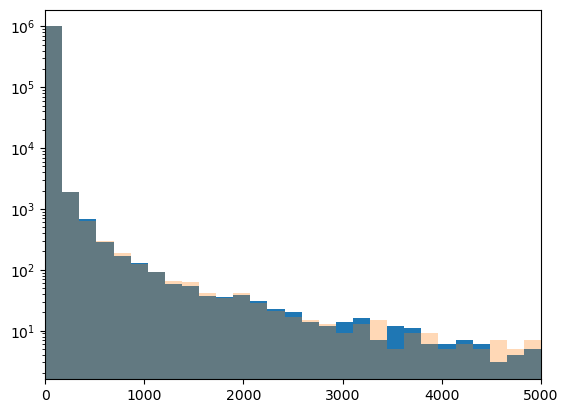

In [96]:
bins = np.linspace(0, 5000, 30)
plt.hist(pm.draw(pm.HalfCauchy.dist(1, 1, size=1000000)), bins=bins)
plt.hist(pm.draw(hc_rv(1, 1, size=1000000)), bins=bins, alpha=0.3)
plt.xlim(0, 5000)
plt.yscale('log')

In [18]:
# Subclassing `PositiveContinuous` will dispatch a default `log` transformation
class HalfCauchy(PositiveContinuous):
    # This will be used by the metaclass `DistributionMeta` to dispatch the
    # class `logp` and `logcdf` methods to the `blah` `Op` defined in the last line of the code above.
    rv_op = hc_rv

    # dist() is responsible for returning an instance of the rv_op.
    # We pass the standard parametrizations to super().dist
    @classmethod
    def dist(cls, param1, param2=None, alt_param2=None, **kwargs):
        param1 = pt.as_tensor_variable(param1)
        if param2 is not None and alt_param2 is not None:
            raise ValueError("Only one of param2 and alt_param2 is allowed.")
        if alt_param2 is not None:
            param2 = 1 / alt_param2
        param2 = pt.as_tensor_variable(param2)

        # The first value-only argument should be a list of the parameters that
        # the rv_op needs in order to be instantiated
        return super().dist([param1, param2], **kwargs)

    
    # moment returns a symbolic expression for the stable moment from which to start sampling
    # the variable, given the implicit `rv`, `size` and `param1` ... `paramN`.
    # This is typically a "representative" point such as the the mean or mode.
    def moment(rv, size, param1, param2):
        moment, _ = pt.broadcast_arrays(param1, param2)
        if not rv_size_is_none(size):
            moment = pt.full(size, moment)
        return moment

    # Logp returns a symbolic expression for the elementwise log-pdf or log-pmf evaluation
    # of the variable given the `value` of the variable and the parameters `param1` ... `paramN`.
    def logp(value, param1, param2):
        # logp_expression = value * (param1 + pt.log(param2))
        logp_expression = pm.logp(pm.HalfCauchy.dist(param1, param2), value)
        
        # # A switch is often used to enforce the distribution support domain
        # bounded_logp_expression = pt.switch(
        #     # pt.gt(value >= 0),
        #     pt.gt(value, 0),
        #     logp_expression,
        #     -np.inf,
        # )
        bounded_logp_expression = logp_expression
        
        # We use `check_parameters` for parameter validation. After the default expression,
        # multiple comma-separated symbolic conditions can be added.
        # Whenever a bound is invalidated, the returned expression raises an error
        # with the message defined in the optional `msg` keyword argument.
        return check_parameters(
            bounded_logp_expression,
            param2 >= 0,
            msg="param2 >= 0",
        )

    # # logcdf works the same way as logp. For bounded variables, it is expected to return
    # # `-inf` for values below the domain start and `0` for values above the domain end.
    # def logcdf(value, param1, param2):
    #     ...
        
    # def icdf(value, param1, param2):
    #     ...

In [49]:

hc = HalfCauchy.dist(param1=1, param2=1)
pm.draw(hc, random_seed=1)

array(2.95527438)

In [50]:
# Test the moment method
moment(hc).eval()

array(1.)

## Test the logp method

In [ ]:
pm.logp(hc, [-0.5, 1.5]).eval()

array([      -inf, -1.6302377])

In [48]:
pm.logp(pm.HalfCauchy.dist(1, 1), [-0.5, 1.5]).eval()

array([      -inf, -1.6302377])

In [46]:
beta = pt.scalar("beta")
rv = pm.HalfCauchy.dist(beta)
value = pt.scalar("value")
rv_logp = pm.logp(rv, value)
print(rv_logp.eval({value: -0.5, beta: 1})) 
print(rv_logp.eval({value: 1.5, beta: 1})) 

-inf
-1.6302376997264467


In [47]:
import pymc as pm
import pytensor.tensor as pt

mu = pt.scalar("mu")
sigma = pt.scalar("sigma")
rv = pm.Normal.dist(mu, sigma)
value = pt.scalar("value", )
rv_logp = pm.logp(rv, value)
print(rv_logp.eval({value: -0.5, mu: 1, sigma: 1})) 
print(rv_logp.eval({value: 1.5, mu: 1, sigma: 1})) 

-2.0439385332046727
-1.0439385332046727


In [52]:
# # Test the logcdf method
# pm.logcdf(blah, [-0.5, 1.5]).eval()
# # array([-1.17591177, -0.06914345])

# Custom distribution

In [160]:

# dist parameters:
# n_samples: a vector of ints, one for each population or locus
# model parameters:
# split time
# migration rate

# I CAN ONLY DO TIMEHOMOGENEOUS MODELS WHERE I HAVE THE PDF..... NO becuase I compute logp from ton expectations...


def mydist_rvs():
    n_samples = 4
    popgen_param1 = 0.5
    x = list(range(1, n))
    probs = scipy.stats.geom.pmf(x, popgen_param1)
    p_vector = probs / probs.sum()
    sample = np.zeros(n_samples-1)
    draw = np.random.choice(x, 1, p=p_vector) - 1
    sample[draw] = 1
    return sample

def mydist_logp(vec):
    n_samples = 4    
    popgen_param1 = 0.5
    ton = np.argmax(vec) + 1
    return np.log(scipy.stats.geom.pmf(ton, popgen_param1)) # should be pt.log...


sample = mydist_rvs()
logp = mydist_logp(sample)
sample, logp

(array([0., 1., 0.]), -1.3862943611198906)

In [141]:
def mydist(rng, loc, scale, size):

fig, ax = plt.subplots(1, 1)
x = list(range(1, n))
print(x)
ax.plot(x, scipy.stats.geom.pmf(x, p), 'bo', ms=8, label='geom pmf')
ax.vlines(x, 0, scipy.stats.geom.pmf(x, p), colors='b', lw=5, alpha=0.5) ;

IndentationError: expected an indented block after function definition on line 1 (4217996490.py, line 3)

# the function should produce n-1 probabilies, one for each ton

In [102]:
def mydist(rng, loc, scale, size):
    return scipy.stats.geom.rvs(loc, scale, random_state=rng, size=size)

rng = np.random.RandomState()
mydist(rng, 0, 1, size=10)

ValueError: Domain error in arguments. The `scale` parameter must be positive for all distributions, and many distributions have restrictions on shape parameters. Please see the `scipy.stats.geom` documentation for details.

In [ ]:
mydist(loc, scale, rng, size=10)